In [27]:
import importlib
from pathlib import Path
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyabf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.io import loadmat
from scipy import ndimage
from scipy.spatial import distance
from scipy.stats import skew
from sklearn.decomposition import PCA
from PIL import Image
from matplotlib.patches import Ellipse

import lmfit
from lmfit import Model

import abf_to_grid as ag
from asymmetry import utils, plot_tools

%matplotlib widget

## Thesis chapter 5

In [17]:
#cell 2
cell2_datapath = Path(r'C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\2\17503013_rec.abf')

# cell 3
cell3_datapath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\3\17809006.abf")

# cell 4
cell4_datapath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\4\17726004.abf")

# cell 5
cell5_datapath_10 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427009.abf") # 10x10 max separation
cell5_protocolpath_10 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\5\maxSep10x10_20percent10ms.txt")
cell5_datapath_29 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427010.abf") # 29x29
cell5_protocolpath_29 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\5\rand29x29_50perc20ms.txt")
cell5_datapath_59 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\18427011.abf") # 59roi29
cell5_protocolpath_59 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\5\59xgrid29roi_100perc10ms.txt")

# cell 6: matlab file
# cell6_datapath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\6\Expt1_300517.mat") # CaMK18 300517

# protocols
protocol_path0 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\10x10_100perc_10ms.txt")
protocol_path1 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Aug18\Grid_29x29_50perc_10ms_rand.txt") #x
protocol_path3 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\others\Polygon-May2017\300517-random29x2910ms50percent.txt") #x
protocol_path4 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Aug18\29x29_50perc_10ms_rand.txt")
protocol_path5 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Protocols\Polygon\Sep18\29x29_50perc_10ms_rand.txt")
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\5\Expt10_29x29rand_50perc_20ms\Grid59roi29_random.txt")
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\59xgrid29roi_100perc10ms.txt")

In [28]:
fig_folder = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots")
plt.close('all')
importlib.reload(ag)

# stim_times = np.arange(49743, 16869273, 20000)[:834]
stim_times_10, peak_df_10, df_pivot_peak_10, df_pivot_auc_10, fig1_10, fig2_10, _, _ = ag.plot_heatmap(cell5_datapath_10, cell5_protocolpath_10,stim_times=None,expected_stims=100,clip_value=120,stim_threshold=10,protocol_order='random')
stim_times_29, peak_df_29, df_pivot_peak_29, df_pivot_auc_29, fig1_10, fig2_29, _, _ = ag.plot_heatmap(cell5_datapath_29, cell5_protocolpath_29,stim_times=None,expected_stims=841,clip_value=120,stim_threshold=10,protocol_order='random')
stim_times_59, peak_df_59, df_pivot_peak_59, df_pivot_auc_59, fig1_10, fig2_59, _, _ = ag.plot_heatmap(cell5_datapath_59, cell5_protocolpath_59,stim_times=None,expected_stims=841,clip_value=120,stim_threshold=10,protocol_order='random')

# cell2_stim_times_59, cell2_peak_df_59, cell2_df_pivot_peak_59, cell2_df_pivot_auc_59, cell2_fig1_10, cell2_fig2_59, _, _ = ag.plot_heatmap(cell2_datapath, cell5_protocolpath_29, stim_times=None,expected_stims=841,clip_value=120,stim_threshold=10,protocol_order='random')
# cell3_stim_times_59, cell3_peak_df_59, cell3_df_pivot_peak_59, cell3_df_pivot_auc_59, cell3_fig1_10, cell3_fig2_59, _, _ = ag.plot_heatmap(cell3_datapath, cell5_protocolpath_29, stim_times=None,expected_stims=841,clip_value=120,stim_threshold=10,protocol_order='random')
# cell4_stim_times_59, cell4_peak_df_59, cell4_df_pivot_peak_59, cell4_df_pivot_auc_59, cell4_fig1_10, cell4_fig2_59, _, _ = ag.plot_heatmap(cell4_datapath, cell5_protocolpath_29, stim_times=None,expected_stims=841,clip_value=120,stim_threshold=10,protocol_order='random')

# response_distribution = df_pivot_auc_29.to_numpy()[5:,:]

<module 'abf_to_grid' from 'c:\\Users\\adity\\OneDrive\\NCBS\\Lab\\Projects\\Asymmetries\\Analysis\\Asymmetries-Analysis-Scripts\\abf_to_grid.py'>

In [4]:
def get_asymmetry(response_distribution, clip_soma=True, th=50, plot=False, plot_mask=False, sensitivity=1, ax=None):
    gridsize = response_distribution.shape[0]
    if clip_soma:
        response_distribution = np.where(response_distribution < np.percentile(response_distribution,95), response_distribution, 0)
    
    x = np.where(response_distribution > np.percentile(response_distribution,th), 1, 0)
    y = np.where(response_distribution > np.percentile(response_distribution,th), response_distribution, 0)

    y = y**sensitivity

    gomy, gomx = ndimage.center_of_mass(x)
    comy, comx = ndimage.center_of_mass(y)
    dist = distance.euclidean((comx/ gridsize, comy/ gridsize), (gomx/ gridsize, gomy/ gridsize))
    if plot:
        if not ax:
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(response_distribution, cmap='magma', origin='lower')
        ax.imshow(x, alpha=0.2, cmap='grey', origin='lower') if plot_mask else None
        hh,hw = response_distribution.shape[0]//2, response_distribution.shape[1]//2

        # draw a straight line with arrowhead connecting the two points
        ax.annotate('', xy=(comx, comy), xytext=(gomx, gomy),arrowprops=dict(facecolor='white', shrink=0.1, edgecolor='white'),)
        ax.scatter(hw, hh, c='b', s=200, marker='o', label='frame centre', )
        ax.scatter(comx, comy, c='g', s=200,marker='*', label='excitation centre',)
        ax.scatter(gomx, gomy, c='k', s=200,marker='+', label='anatomical centre',)

        # add distance as a measure of asymmetry as text annoation
        ax.text(0.95, 0.8, f'Asymmetry = {dist:.2f}', color='w', fontsize=20, ha='right', va='center', transform=ax.transAxes)

        ax.legend(fontsize=20)
        # remove axis
        ax.axis('off')
        # tight layout
        plt.tight_layout()

    return dist, [[np.round(gomx,2), np.round(gomy,2)],[np.round(comx,2), np.round(comy,2)]], ax

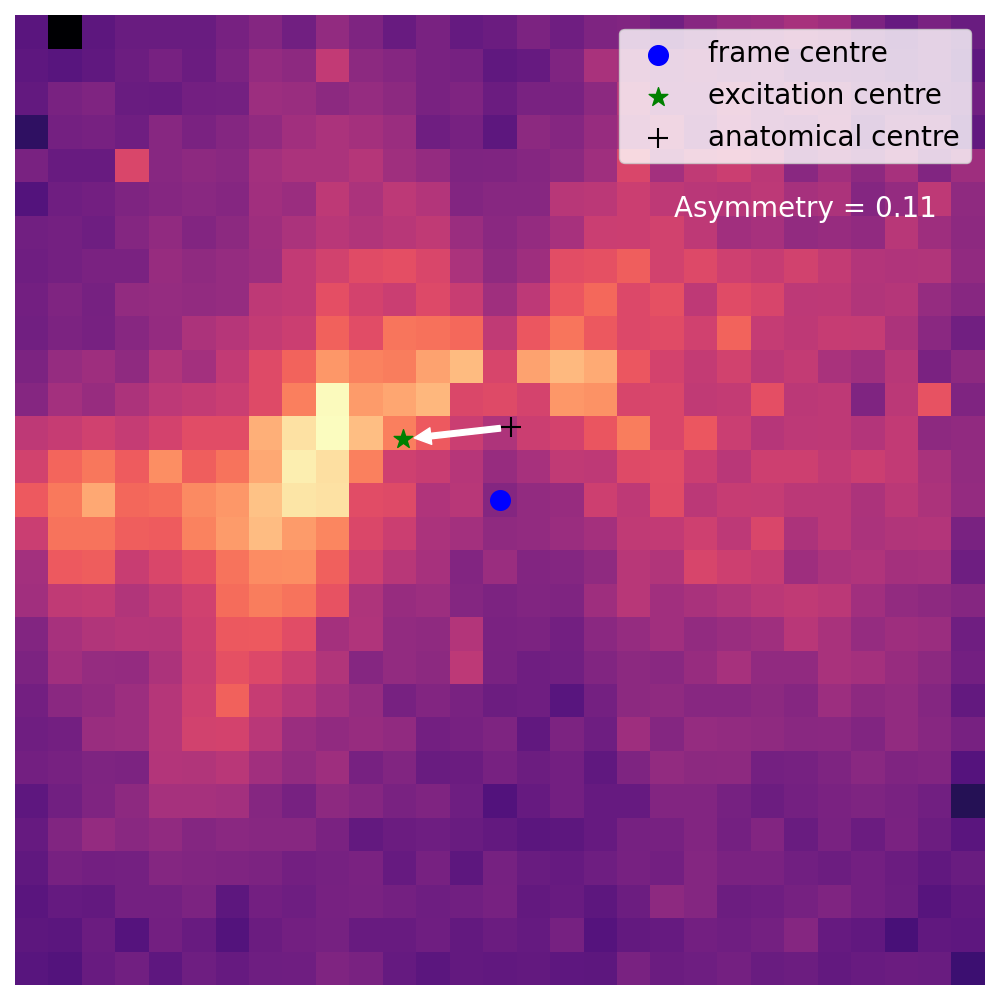

In [5]:
# plot heatmap with distance
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
_,_,ax = get_asymmetry(df_pivot_auc_29, clip_soma=False, th=41, sensitivity=4, plot=True, ax=ax)
# save fig
fig.savefig(fig_folder / 'asymmetry_centreofmass_29x29.png')
fig.savefig(fig_folder / 'asymmetry_centreofmass_29x29.svg')

## Using polyfit to measure asymmetry

Centroid of the heat distribution (center of mass): [16.1394 13.6758]
Principal Components (Directions of Heat Distribution):
[[ 0.2778  0.9606]
 [ 0.9606 -0.2778]]

Explained Variance by each component: [0.7442 0.2558]


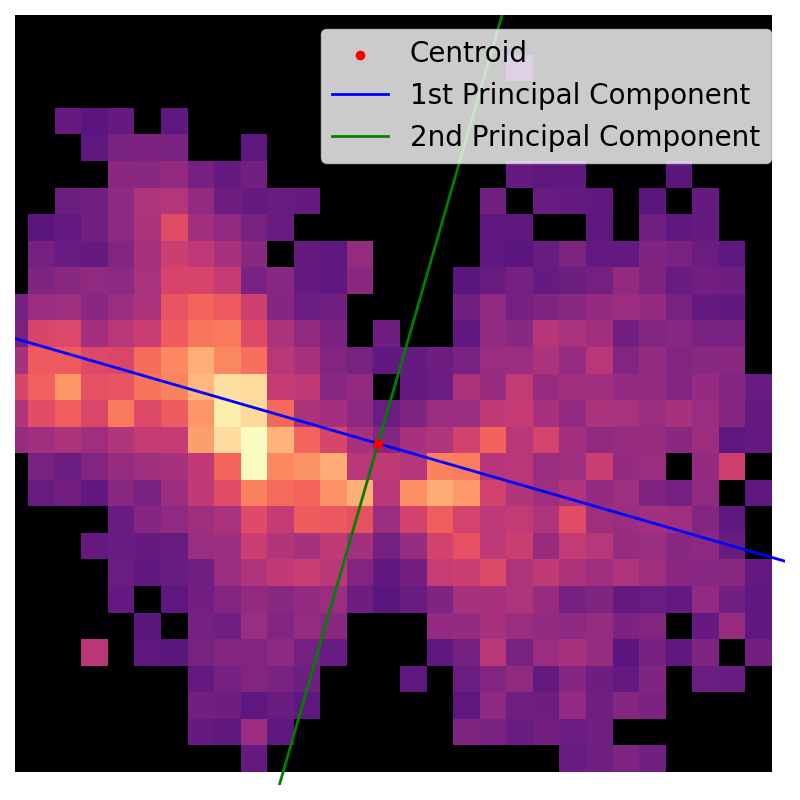

In [10]:
# skewness
import numpy as np
import matplotlib.pyplot as plt


# heatmap is the df obtained above
heatmap = np.where(df_pivot_auc_29 > np.percentile(df_pivot_auc_29,41), df_pivot_auc_29, 0)
# load from image
# imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
# image = Image.open(imagepath)
# heatmap = np.array(image)
# convert to grayscale if necessary
if heatmap.ndim == 3:
    heatmap = heatmap.mean(axis=2)


# -------------------------------------------
# Step 2: Recentered PCA (Principal Component Analysis)
# -------------------------------------------
# Get the coordinates of non-zero intensity pixels (to focus on relevant data)
coords = np.argwhere(heatmap > 0)

# Get the corresponding intensities for those coordinates
intensities = heatmap[coords[:, 0], coords[:, 1]]

# Calculate the centroid (center of mass) of the heatmap, weighted by intensity
centroid = np.average(coords, axis=0, weights=intensities)

print(f"Centroid of the heat distribution (center of mass): {centroid}")

# Recenter the coordinates by subtracting the centroid
recentered_coords = coords - centroid

# Prepare the data by weighting the recentered coordinates with the intensity
# This ensures that higher intensity pixels contribute more to the PCA
weighted_coords = recentered_coords * intensities[:, np.newaxis]

# Perform PCA on the recentered and weighted coordinates
pca = PCA(n_components=2)
pca.fit(weighted_coords)

# Extract the principal axes (directions of maximum variance)
principal_axes = pca.components_

# Explained variance: tells us how much of the variance is explained by each component
explained_variance = pca.explained_variance_ratio_

print("Principal Components (Directions of Heat Distribution):")
print(principal_axes)

print(f"\nExplained Variance by each component: {explained_variance}")
# The first component explains most of the variance (~84%), showing the dominant orientation of the heat distribution

# -------------------------------------------
# Optional: Visualize the principal components on the heatmap
# -------------------------------------------
plt.figure(figsize=(8, 8))
# Plot the heatmap
plt.imshow(heatmap, cmap='magma')
# Draw the centroid
plt.scatter(centroid[1], centroid[0], color='red', label='Centroid', zorder=5)

# Calculate the center of the image
image_center = np.array(heatmap.shape) // 2

# Scale the principal axes for visualization
axis_length = 100  # Length of the axes to display

# Draw the first principal axis (dominant direction of heat)
plt.plot([centroid[1]-axis_length * principal_axes[0, 1], centroid[1] + axis_length * principal_axes[0, 1]],
         [centroid[0]-axis_length * principal_axes[0, 0], centroid[0] + axis_length * principal_axes[0, 0]],
         color='blue', label='1st Principal Component', linewidth=2)

# Draw the second principal axis (secondary direction of heat)
plt.plot([centroid[1]-axis_length * principal_axes[1, 1], centroid[1] + axis_length * principal_axes[1, 1]],
         [centroid[0]-axis_length * principal_axes[1, 0], centroid[0] + axis_length * principal_axes[1, 0]],
         color='green', label='2nd Principal Component', linewidth=2)

# Add legend and titles
# plt.title("Heatmap with Principal Components (Recentered)")
plt.legend(loc="upper right", fontsize=20)
# limits
plt.xlim(0, heatmap.shape[1])
plt.ylim(heatmap.shape[0], 0)

plt.axis('off')
plt.tight_layout()

# -------------------------------------------
# Summary of Results:
# - We now calculate the centroid (center of mass) of the heat distribution to account for off-center heat streaks.
# - PCA is applied to recentered coordinates to detect the true orientation of the heat distribution.
# - The principal components (blue and green lines) represent the dominant and secondary axes of heat spread.
# -------------------------------------------
# save fig
plt.savefig(fig_folder / 'pca_heatmap.png')
plt.savefig(fig_folder / 'pca_heatmap.svg')


## Fit an ellipse

Use the covariance matrix of the coordinates (weighted by their intensity) to determine the major and minor axes of the ellipse.

'''
Great questions! Let’s dive into the details of how the covariance matrix, eigenvalues, and eigenvectors are used to fit the ellipse.

### 1. **Why use the covariance matrix of the coordinates (weighted by their intensity) to determine the major and minor axes of the ellipse?**

The covariance matrix provides key information about the **spread** (or variance) of data in different directions. In your case, we are working with spatial coordinates of the heatmap's intensity values. Here's why the covariance matrix is helpful:

- **Covariance** measures how much two variables (in this case, x and y coordinates of pixels) change together. In a two-dimensional dataset like an image, the covariance matrix summarizes how the data is distributed across the x and y axes.
  
- **Weighted by intensity**: Since pixel intensities represent the "heat" distribution, we weight the coordinates by their intensity. This ensures that areas with higher heat values contribute more to the spread of data, which is critical for fitting the ellipse around the "hot" regions.

- The **eigenvalues** of the covariance matrix correspond to the amount of variance along specific directions (these directions are the eigenvectors). The **larger the eigenvalue**, the more spread there is along that direction, which helps us define the major and minor axes of the ellipse.

- **In summary**: The covariance matrix tells us how the heat distribution is spread spatially. By using it, we can derive the orientation and elongation of the ellipse that best fits the spatial arrangement of the heat, based on its variance along different directions.

### 2. **Where and how is the actual fitting happening?**

There’s no explicit "curve fitting" function in the code like those used for fitting parametric curves. Instead, the ellipse fitting here is implicit and happens through **eigen decomposition** of the covariance matrix.

#### Here’s how this works:

- The **eigenvectors** of the covariance matrix give the **principal directions** (or axes) along which the data (the spatial distribution of the heat) is most spread out. These directions are essentially the orientation of the ellipse.

- The **eigenvalues** represent the amount of variance along each eigenvector direction. The square root of the eigenvalue gives the **length of the axis** corresponding to that eigenvector. In an ellipse, these are the lengths of the **major and minor axes**.

Thus, the **fitting** happens by:
1. Calculating the **covariance matrix** of the data points (weighted by their intensity).
2. Performing **eigen decomposition** on this matrix to get the **eigenvalues** and **eigenvectors**.
3. The **eigenvalues** give the lengths of the major and minor axes, while the **eigenvectors** give the direction (orientation) of these axes.

There’s no need for an explicit curve-fitting function because we’re not trying to fit a parametric curve to a dataset. Instead, we’re deriving the best-fitting ellipse directly from the spread of the data using the covariance matrix and eigen decomposition.

### Ellipse Fitting Intuition:
- Imagine you have a cloud of points (the heatmap's hot regions). If you wanted to fit an ellipse around this cloud:
  1. You'd find the two directions in which the points are most spread out (these are the eigenvectors).
  2. The amount of spread along each direction determines the size of the ellipse along those axes (eigenvalues).

This process effectively fits an ellipse by capturing the **spatial distribution** of the data, rather than relying on an explicit curve-fitting algorithm.

### Summary:
- **Covariance matrix**: Provides information on how the data (heatmap coordinates) is spread in 2D space.
- **Eigen decomposition**: Transforms the spread information into the axes and orientation of the best-fitting ellipse, using the eigenvalues (for axis lengths) and eigenvectors (for directions).
  
By leveraging the statistical properties of the data (via the covariance matrix and eigen decomposition), we're able to fit an ellipse around the heat distribution without needing to explicitly define a parametric ellipse and fit it.

'''

Major Axis Length: 15.84
Minor Axis Length: 10.18
Orientation (angle): 16.14 degrees
Major / Minor Axis Ratio: 1.55


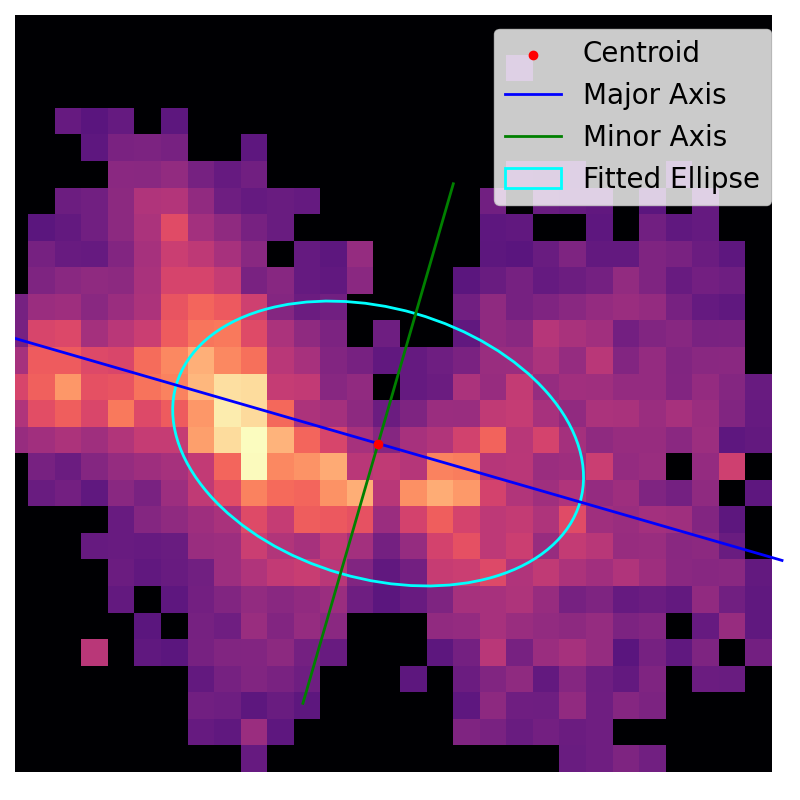

In [62]:


# heatmap is the df obtained above
heatmap = np.where(df_pivot_auc_29 > np.percentile(df_pivot_auc_29,41), df_pivot_auc_29, 0)
# load from image
# imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
# image = Image.open(imagepath)
# heatmap = np.array(image)
# convert to grayscale if necessary
if heatmap.ndim == 3:
    heatmap = heatmap.mean(axis=2)

# -------------------------------------------
# Step 1: Calculate the centroid (center of mass) of the heatmap
# -------------------------------------------
coords = np.argwhere(heatmap > 0)  # Get non-zero pixel coordinates
intensities = heatmap[coords[:, 0], coords[:, 1]]  # Get corresponding intensities

# Calculate the centroid (center of mass), weighted by intensity
centroid = np.average(coords, axis=0, weights=intensities)

# Recenter the coordinates by subtracting the centroid
recentered_coords = coords - centroid

# -------------------------------------------
# Step 2: Covariance Matrix and Eigenvalues (Ellipse Fitting)
# -------------------------------------------
# Calculate the weighted covariance matrix of the recentered coordinates
cov_matrix = np.cov(recentered_coords.T, aweights=intensities)

# Eigen decomposition to get the axes of the ellipse
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort eigenvalues and eigenvectors by the magnitude of the eigenvalues (to get major and minor axes)
order = np.argsort(eigenvalues)[::-1]  # Sort in descending order
eigenvalues = eigenvalues[order]
eigenvectors = eigenvectors[:, order]

# Eigenvalues correspond to the squared lengths of the axes
axis_lengths = 2 * np.sqrt(eigenvalues)  # Factor of 2 to get full lengths of the axes

# Angle of the ellipse (from the first eigenvector)
angle = np.degrees(np.arctan2(eigenvectors[0, 0], eigenvectors[1, 0]))

# -------------------------------------------
# Step 3: Plotting the ellipse over the heatmap
# -------------------------------------------
plt.figure(figsize=(8,8))
# Plot the heatmap
plt.imshow(heatmap, cmap='magma')

# Plot the centroid
plt.scatter(centroid[1], centroid[0], color='red', label='Centroid', zorder=5)

# Plot the fitted ellipse
ellipse = Ellipse(
    xy=(centroid[1], centroid[0]),  # Center of the ellipse (centroid)
    width=axis_lengths[0],  # Major axis length
    height=axis_lengths[1],  # Minor axis length
    angle=angle,  # Rotation of the ellipse
    edgecolor='cyan',
    fc='none',  # No fill
    lw=2,
    label='Fitted Ellipse'
)
# draw major and minor axes of the ellipse
plt.plot([centroid[1]-axis_lengths[0] * eigenvectors[1, 0], centroid[1] + axis_lengths[0] * eigenvectors[1, 0]],
         [centroid[0]-axis_lengths[0] * eigenvectors[0, 0], centroid[0] + axis_lengths[0] * eigenvectors[0, 0]],
         color='blue', label='Major Axis', linewidth=2)

plt.plot([centroid[1]-axis_lengths[1] * eigenvectors[1, 1], centroid[1] + axis_lengths[1] * eigenvectors[1, 1]],
         [centroid[0]-axis_lengths[1] * eigenvectors[0, 1], centroid[0] + axis_lengths[1] * eigenvectors[0, 1]],
         color='green', label='Minor Axis', linewidth=2)
plt.gca().add_patch(ellipse)

# Add legend and titles
# plt.title("Fitted Ellipse on Heatmap")
plt.legend(loc="upper right", fontsize=20)
# xlim
plt.xlim(0, heatmap.shape[1])
plt.ylim(heatmap.shape[0], 0)

plt.axis('off')
plt.tight_layout()


# Output the results (axis lengths and orientation)
print(f"Major Axis Length: {axis_lengths[0]:.2f}")
print(f"Minor Axis Length: {axis_lengths[1]:.2f}")
print(f"Orientation (angle): {angle:.2f} degrees")
print(f"Major / Minor Axis Ratio: {axis_lengths[0] / axis_lengths[1]:.2f}")

# save fig
plt.savefig(fig_folder / 'ellipse_fit_29x29.png')
plt.savefig(fig_folder / 'ellipse_fit_29x29.svg')

Major Axis (North-South) Asymmetry: 2.76%
[np.float64(14.705773788452147), np.float64(15.541504547119139)]
Minor Axis (East-West) Asymmetry: 3.65%
[np.float64(15.675570510864258), np.float64(14.571707824707032)]


C:\Users\adity\AppData\Local\Temp\ipykernel_25488\3138976009.py:92: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(8,8))


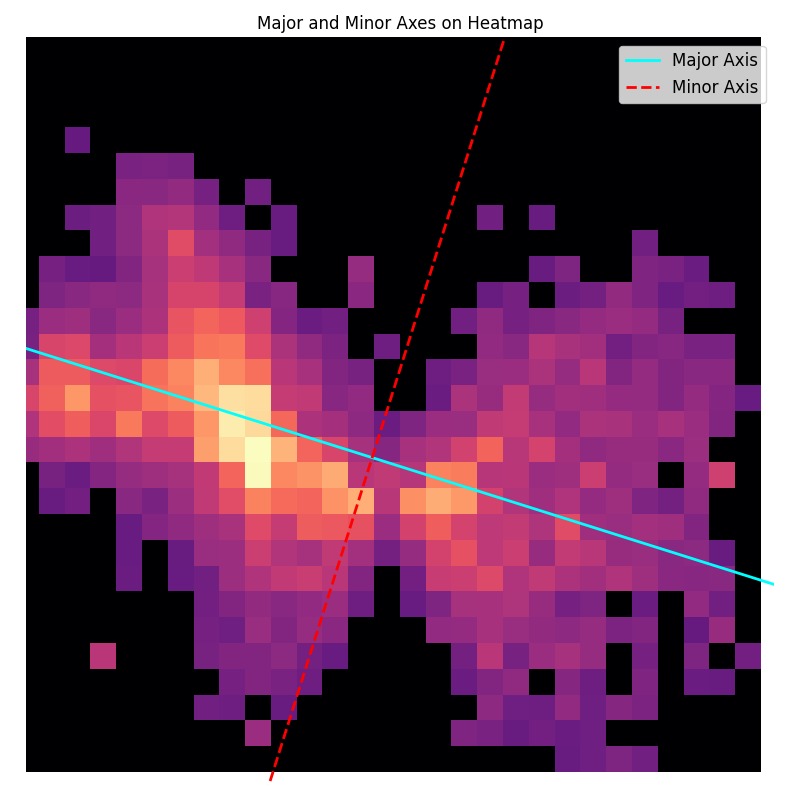

In [15]:

# heatmap is the df obtained above
heatmap = np.where(df_pivot_auc_29 > np.percentile(df_pivot_auc_29,50), df_pivot_auc_29, 0)
# load from image
# imagepath = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Analysis\Plots\test_heatmap.png")
# image = Image.open(imagepath)
# heatmap = np.array(image)
# convert to grayscale if necessary
if heatmap.ndim == 3:
    heatmap = heatmap.mean(axis=2)

# -------------------------------------------
# Step 1: Calculate the centroid (center of mass) of the heatmap
# -------------------------------------------
coords = np.argwhere(heatmap > 0)  # Get non-zero pixel coordinates
intensities = heatmap[coords[:, 0], coords[:, 1]]  # Get corresponding intensities

# Calculate the centroid (center of mass), weighted by intensity
centroid = np.average(coords, axis=0, weights=intensities)

# Recenter the coordinates by subtracting the centroid
recentered_coords = coords - centroid

# -------------------------------------------
# Step 2: Apply PCA to find the major and minor axes
# -------------------------------------------
# Prepare the data by weighting the coordinates with the intensity
weighted_coords = recentered_coords * intensities[:, np.newaxis]

# Perform PCA on the recentered and weighted coordinates
pca = PCA(n_components=2)
pca.fit(weighted_coords)

# Get the major (first component) and minor (second component) axes
major_axis = pca.components_[0]  # Major axis (east-west)
minor_axis = pca.components_[1]  # Minor axis (north-south)

# -------------------------------------------
# Step 3: Project points onto the major and minor axes and calculate asymmetry
# -------------------------------------------

# Normalize the axes
major_axis = major_axis / np.linalg.norm(major_axis)
minor_axis = minor_axis / np.linalg.norm(minor_axis)

# 1. Project each point onto the major axis (for north-south asymmetry)
major_projections = np.dot(recentered_coords, major_axis)

# 2. Project each point onto the minor axis (for east-west asymmetry)
minor_projections = np.dot(recentered_coords, minor_axis)

# -------------------------------------------
# Major Axis (North-South) Asymmetry
# -------------------------------------------
# Split the data into two halves (north vs. south)
north_side_indices = major_projections > 0  # Points above the major axis (north)
south_side_indices = major_projections < 0  # Points below the major axis (south)

# Calculate the total heat (intensity) on each side of the major axis
north_side_heat_major = np.sum(intensities[north_side_indices])
south_side_heat_major = np.sum(intensities[south_side_indices])

# Calculate percentage asymmetry for major axis (north vs. south)
total_heat_major = north_side_heat_major + south_side_heat_major
asymmetry_major = abs(north_side_heat_major - south_side_heat_major) / total_heat_major * 100

# -------------------------------------------
# Minor Axis (East-West) Asymmetry
# -------------------------------------------
# Split the data into two halves (east vs. west)
east_side_indices = minor_projections > 0  # Points on the east side
west_side_indices = minor_projections < 0  # Points on the west side

# Calculate the total heat (intensity) on each side of the minor axis
east_side_heat_minor = np.sum(intensities[east_side_indices])
west_side_heat_minor = np.sum(intensities[west_side_indices])

# Calculate percentage asymmetry for minor axis (east vs. west)
total_heat_minor = east_side_heat_minor + west_side_heat_minor
asymmetry_minor = abs(east_side_heat_minor - west_side_heat_minor) / total_heat_minor * 100

# -------------------------------------------
# Output the asymmetry results
# -------------------------------------------
print(f"Major Axis (North-South) Asymmetry: {asymmetry_major:.2f}%")
print([north_side_heat_major , south_side_heat_major])
print(f"Minor Axis (East-West) Asymmetry: {asymmetry_minor:.2f}%")
print([east_side_heat_minor , west_side_heat_minor])

# -------------------------------------------
# Optional: Plot the results
# -------------------------------------------
fig, ax = plt.subplots(figsize=(8,8))

# Plot the heatmap in the background
ax.imshow(heatmap, cmap='magma')

# Plot the major axis (cyan) and minor axis (red dashed)
axis_length = 100  # Length of the axis for display purposes
ax.plot([centroid[1]-axis_length * major_axis[1], centroid[1] + axis_length * major_axis[1]],
        [centroid[0]-axis_length * major_axis[0], centroid[0] + axis_length * major_axis[0]],
        color='cyan', label='Major Axis', linewidth=2)

ax.plot([centroid[1]-axis_length * minor_axis[1], centroid[1] + axis_length * minor_axis[1]],
        [centroid[0]-axis_length * minor_axis[0], centroid[0] + axis_length * minor_axis[0]],
        color='red', linestyle='dashed', label='Minor Axis', linewidth=2)

# Add legend and show the plot
ax.legend(loc='upper right', fontsize=20)
plt.title("Major and Minor Axes on Heatmap")
plt.xlim(0, heatmap.shape[1])
plt.ylim(heatmap.shape[0], 0)
plt.legend(fontsize=12)

ax.axis('off')
plt.tight_layout()


# save fig
fig.savefig(fig_folder / 'asymmetry_major_minor_axes_thresholded.png')
fig.savefig(fig_folder / 'asymmetry_major_minor_axes_thresholded.svg')

shapes:  (210,) (210,) (221,) (199,)
Skewness of the distributions: 
East:  1.2103762035847287
West:  1.6199896295872005
North:  1.5359557657100857
South:  0.9949627824583834
xvalues = ['minor' 'major'], hue_values = ['east' 'west' 'north' 'south']
2.8205736261249967 0.09306313936706945
Comparison # 0, x = minor, statistic=2.8205736261249967, pval=0.09306313936706945
19.13432485240878 1.2183396273552399e-05
Comparison # 1, x = major, statistic=19.13432485240878, pval=1.2183396273552399e-05


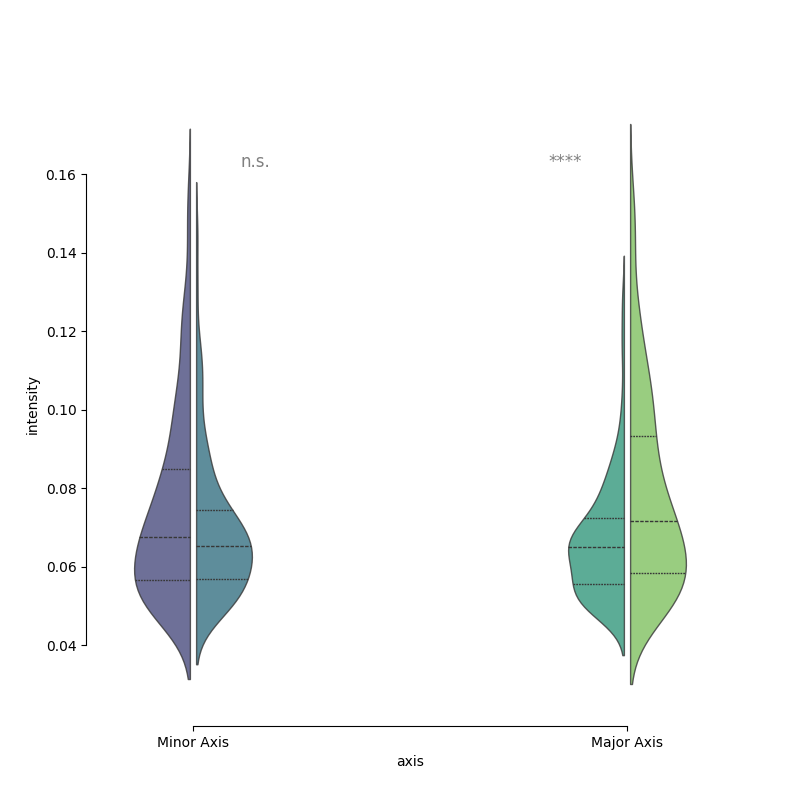

In [26]:
east = pd.Series( np.abs(intensities[east_side_indices]) )
west = pd.Series( np.abs(intensities[west_side_indices]) )
north = pd.Series( np.abs(intensities[north_side_indices]) )
south = pd.Series( np.abs(intensities[south_side_indices]) )
print('shapes: ', east.shape, west.shape, north.shape, south.shape)
# make a dataframe
distdf = pd.DataFrame({'east':east, 'west':west, 'north':north, 'south':south}, )
# pivot
distdf = distdf.melt(var_name='direction', value_name='intensity')
# add a column for the axis
distdf['axis'] = distdf['direction'].apply(lambda x: 'major' if x in ['north', 'south'] else 'minor')

fig, ax= plt.subplots(1,1, figsize=(8,8))
# sns.violinplot(x='axis', y='intensity', data=distdf, hue='direction', split=True, inner='quart', palette='tab20', dodge=True, ax=ax)

# calculate skewness for the four distributions
print('Skewness of the distributions: ')
print('East: ', skew(east))
print('West: ', skew(west))
print('North: ', skew(north))
print('South: ', skew(south))

# stat across the two sides
import stat_annotate
from scipy.stats import kruskal
importlib.reload(stat_annotate)
vp = stat_annotate.pairwise_draw_and_annotate_line_plot(ax, distdf, x='axis', y='intensity', hue='direction', draw=True, kind='violin', palette='viridis', split_violins=True, dodge=False,
                                                    stat_across='hue', stat=kruskal, skip_first_xvalue=False, annotate_wrt_data=False, offset_btw_star_n_line=0.1,
                                                    color='grey', coord_system='data', fontsize=12, zorder=10, add_n=False, gap=0.1 ,native_scale=True)
                                                    
# change tick positions on x-axis
vp.set_xticks([-0.2,1.2])
vp.set_xticklabels(['Minor Axis', 'Major Axis'])

# despine
sns.despine(ax=ax, offset=10, trim=True, top=True, right=True)

# 3 save fig
fig.savefig(fig_folder / 'asymmetry_across_PCAaxes_violinplot_29x29.png')
fig.savefig(fig_folder / 'asymmetry_across_PCAaxes_violinplot_29x29.svg')

## kernel-based network activation

In [72]:
kernel = 5*df_pivot_peak_29.to_numpy()
kernel = kernel[5:,:].T

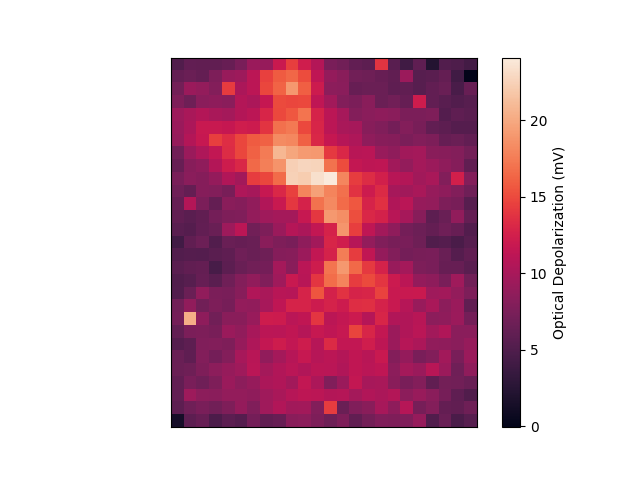

In [73]:
# plot matplotlib heatmap of the kernel
plt.figure()
# layout tight
plt.tight_layout()
plt.imshow(kernel, cmap='rocket', interpolation='nearest')
# remove ticks and labels
plt.xticks([])
plt.yticks([])
# add colourbar axis label
cbar = plt.colorbar()
cbar.set_label('Optical Depolarization (mV)')
# save as svg and png
plt.savefig(fig_folder / f'kernel_convolution_kernel.svg')
plt.savefig(fig_folder / f'kernel_convolution_kernel.png')

actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


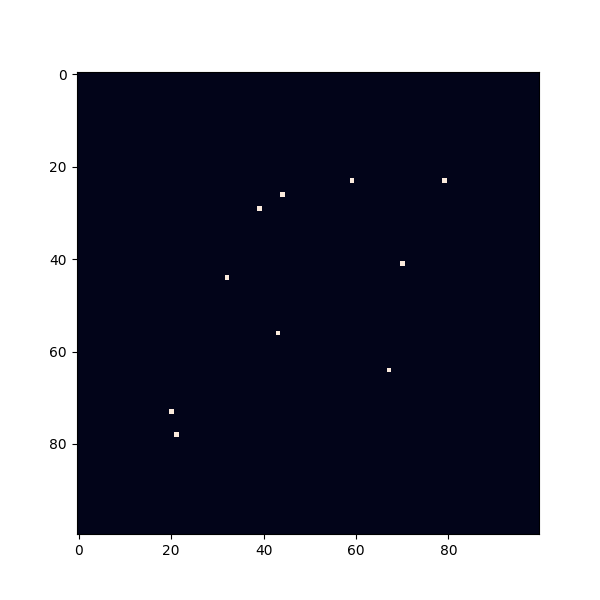

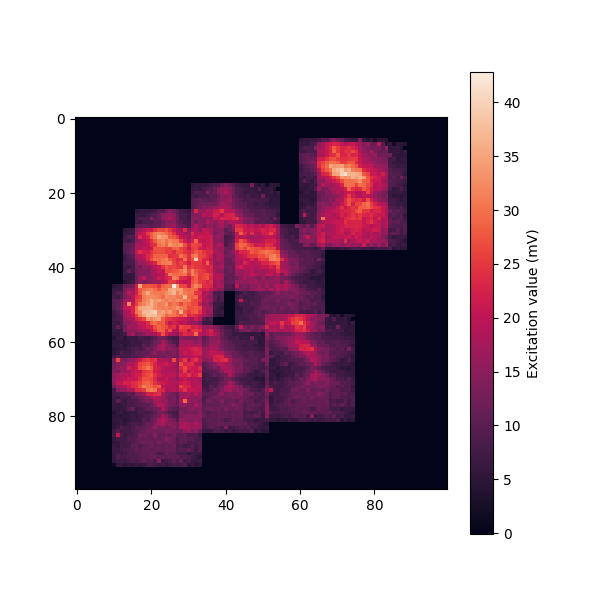

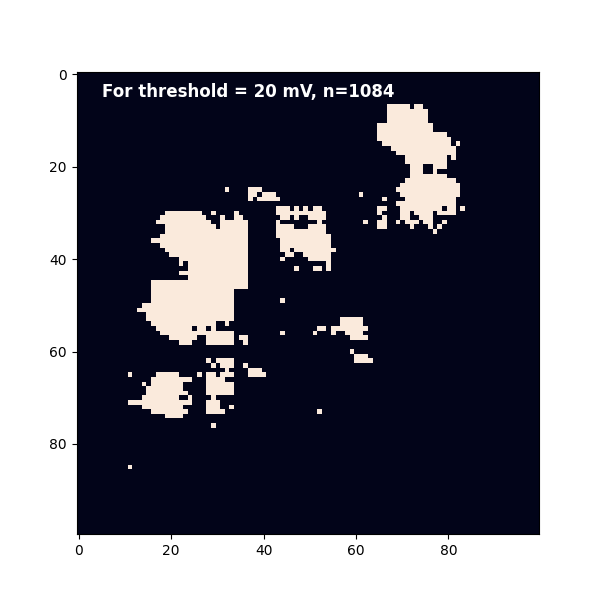

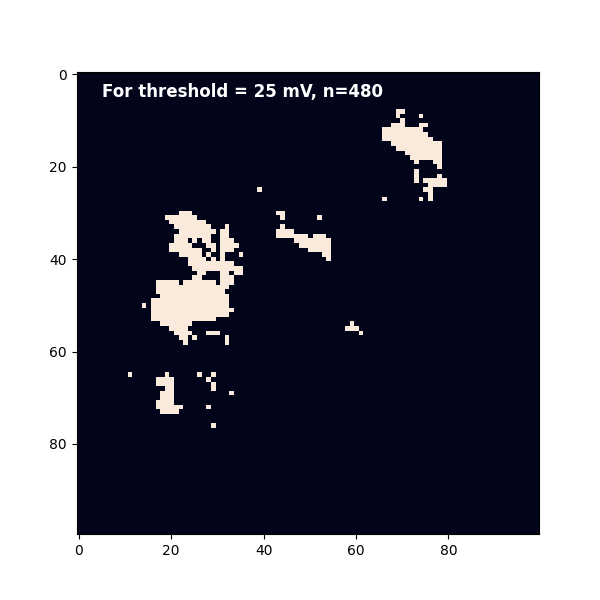

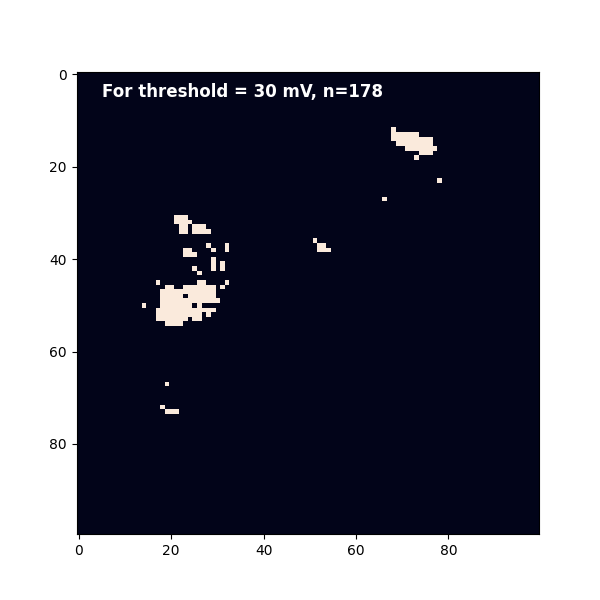

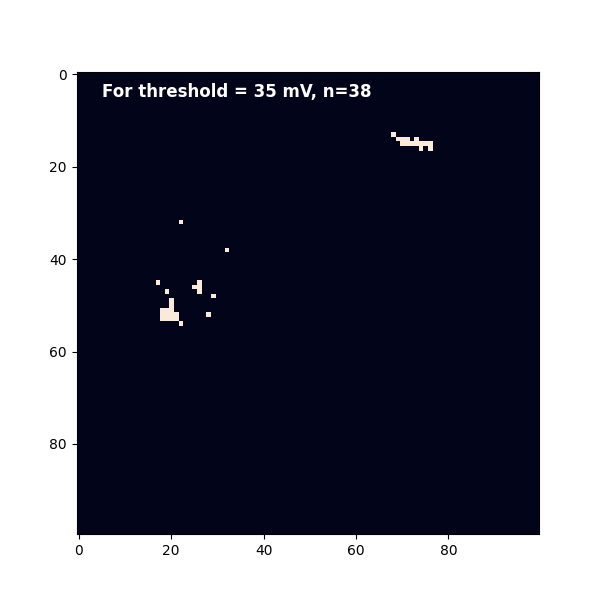

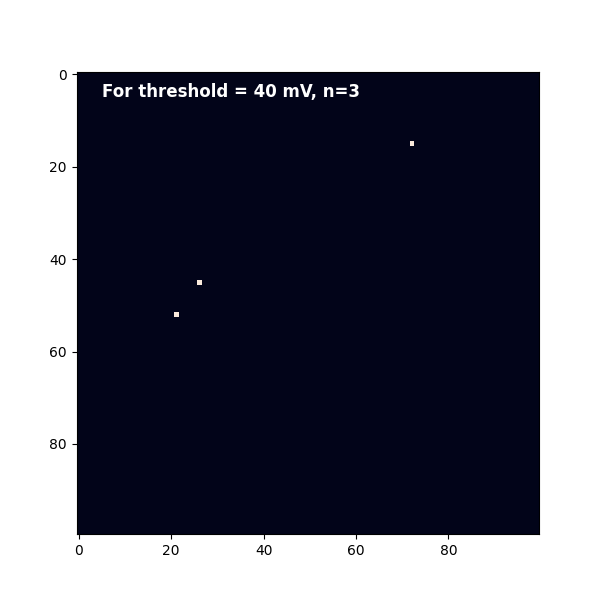

In [61]:
# create a cell layer as a numpy array of 100 x 100 neurons. Randomly select 10 neurons from the whole layer and apply the kernel to them
cell_layer = np.zeros((100,100))
# use a particular random seed state
np.random.seed(0)
neuron_locs = np.random.randint(20, 80,(10,2))
for loc in neuron_locs:
    cell_layer[loc[0],loc[1]] = 1

# apply the kernel to the cell layer for each neuron and add the kernel value for each location
output = np.zeros((100,100))

# import cv2

# output = cv2.filter2D(src=cell_layer, ddepth=-1, kernel=kernel)

# plt.figure()
# plt.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# plt.figure()
# plt.imshow(output, cmap='rocket', interpolation='nearest')
for loc in neuron_locs:
    x1 = loc[0]-13
    x2 = loc[0]+11
    y1 = loc[1]-14
    y2 = loc[1]+15
    # print(x1,x2,x2-x1, y1,y2, y2-y1, kernel.shape)
    output[y1:y2, x1:x2] += kernel
figin, axin = plt.subplots(figsize=(6,6))
axin.imshow(cell_layer, cmap='rocket', interpolation='nearest')
# save fig
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.svg')
figin.savefig(fig_folder / f'kernel_convolution_input_cell_layer.png')

figout, axout = plt.subplots(figsize=(6,6))
axout.imshow(output, cmap='rocket', interpolation='nearest')
# colourbar
cbar = plt.colorbar(axout.imshow(output, cmap='rocket', interpolation='nearest'))
cbar.set_label('Excitation value (mV)')
# save fig
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.svg')
figout.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer.png')

# create a new array by thresholding the output array
threshold = [20,25,30,35,40]
for th in threshold:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>th] = 1
    # plot in a new figure
    figout_thresh, axout_thresh = plt.subplots(figsize=(6,6))
    axout_thresh.imshow(output_thresholded, cmap='rocket', interpolation='nearest')
    # annotate the total number of neurons activated in the figure
    neurons_crossing_threshold = np.sum(output_thresholded)
    axout_thresh.text(5,5,f'For threshold = {th} mV, n={int(neurons_crossing_threshold)}', color='white', fontsize=12, fontweight='bold')
    # save fig
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.svg')
    figout_thresh.savefig(fig_folder / f'kernel_convolution_{th}_thresholded_cell_layer.png')
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')

actual number of neurons activated: 1894.0
actual number of neurons activated: 1084.0
actual number of neurons activated: 480.0
actual number of neurons activated: 178.0
actual number of neurons activated: 38.0
actual number of neurons activated: 3.0


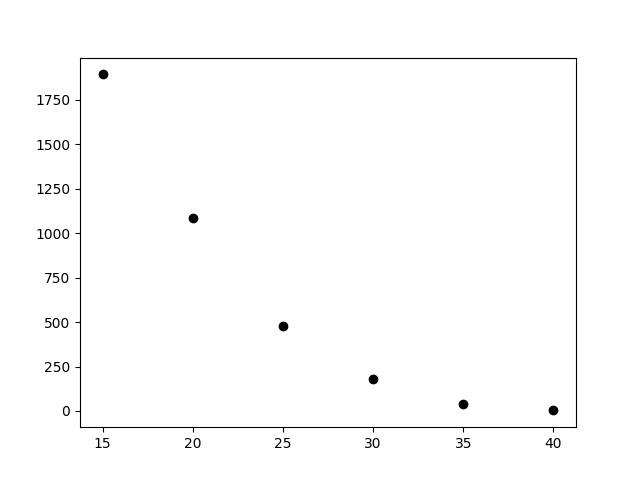

In [57]:
plt.figure()

for i in [15,20,25,30,35,40]:
    output_thresholded = np.zeros_like(output)
    output_thresholded[output>i] = 1
    print(f'actual number of neurons activated: {np.sum(output_thresholded)}')
    plt.scatter(i, np.sum(output_thresholded), color='black')
plt.show()
plt.xlabel('Threshold (a.u.)')
plt.ylabel('Number of activated neurons')
# remove top and right spines
sns.despine()
# save fig
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.svg')
plt.savefig(fig_folder / f'kernel_convolution_convolved_cell_layer_numactivatedcells.png')
    

Loading ABF file
Datafile has 1 sweeps in 2 channels.


c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\venvs\venv-ephys\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


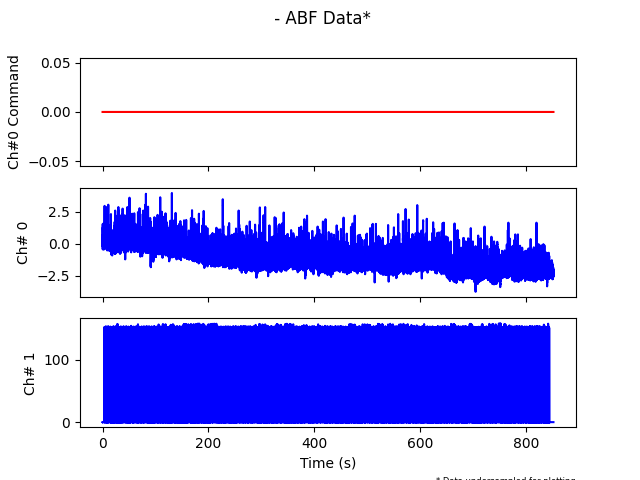

In [16]:
from asymmetry import abf_to_data as ad
from asymmetry import utils

data = ad.abf_to_data(file_path, baseline_subtraction=True,
        signal_scaling=1, sampling_freq=2e4, filter_type='', filter_cutoff=1000,
        data_order="channelwise", plot_data=True)[0][0]

data = data.ravel()

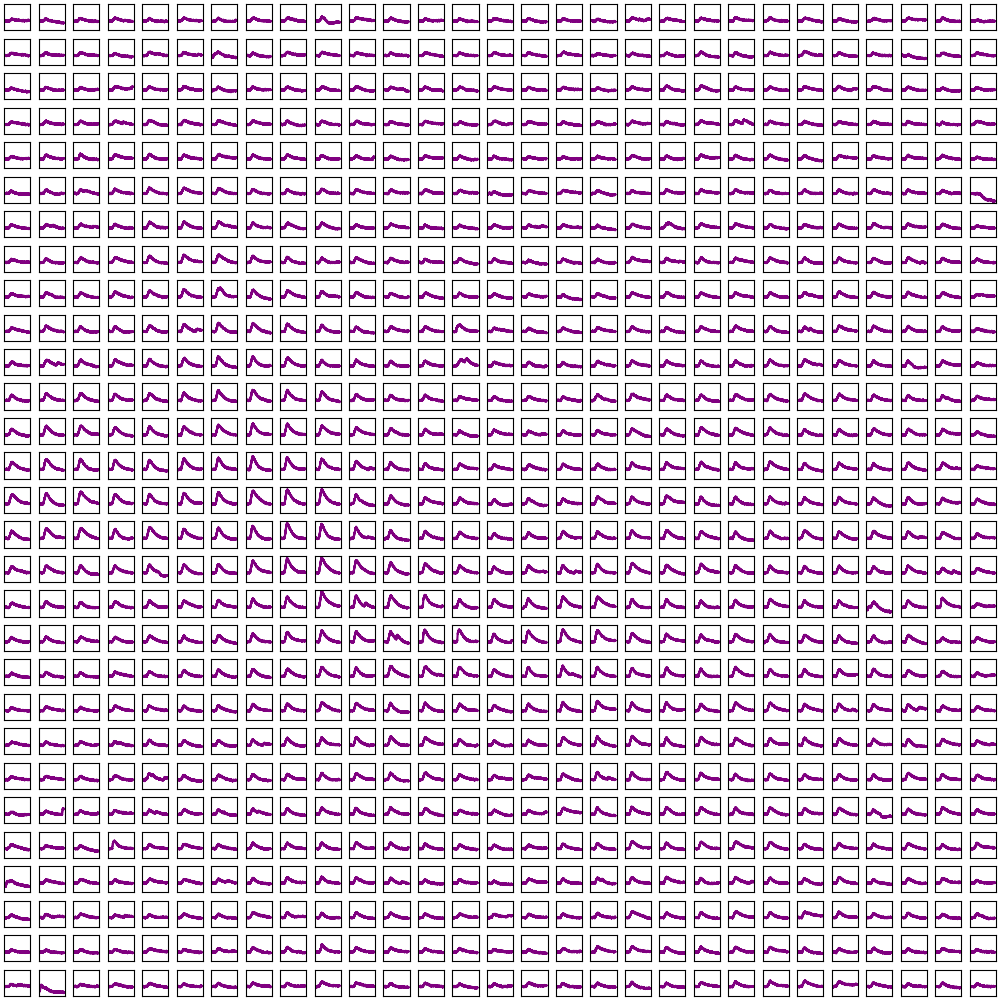

In [17]:
fig, ax = plt.subplots(29,29, figsize=(10,10), sharex=True, sharey=True, layout='constrained')

for k in range(841):
    T0 = -25
    T1 = 175
    x,y = peak_df['x'][k], peak_df['y'][k]
    t0 = int(stim_times[k] + T0*20)
    t1 = int(stim_times[k] + T1*20)
    cellslice = data[t0:t1]
    cellslice = cellslice - np.mean(cellslice[:500])
    ax[x,y].plot(np.linspace(T0, T1, len(cellslice)), cellslice, 'purple')
    # remove all ticks, ticklabels, but keep the bounding box
    ax[x,y].set_xticks([])
    ax[x,y].set_yticks([])
    # ax[x,y].spines['top'].set_visible(False
    # print(k,x,y)
# save fig
filename_prefix = f'CaMKII_27Apr18_expt10'
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.svg')
fig.savefig(fig_folder / f'{filename_prefix}_raw_data.png')


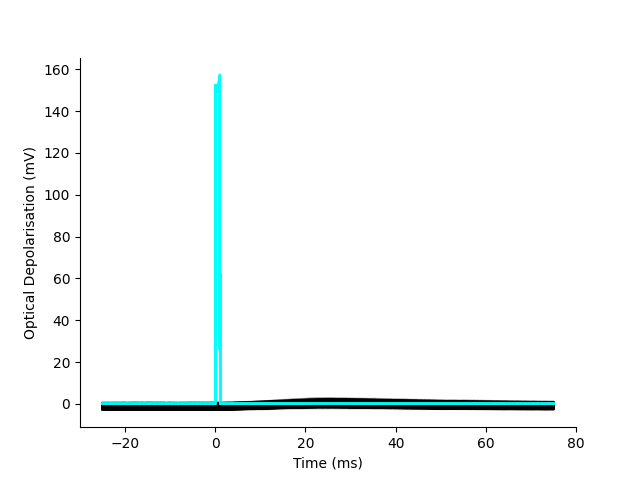

In [46]:
# plot
fig3, ax3 = plt.subplots()
T0,T1 = -25,75
Fs=20
for st in stim_times:
    # print(st)
    t0, t1 = int(st+T0*Fs), int(st+T1*Fs)
    stim_slice = stim[t0:t1]
    cell_slice = cell[t0:t1]
    cellmax = np.max(cell_slice)
    cellauc = np.trapz(cell_slice) / 20000
    time = np.linspace(T0, T1, len(cell_slice))
    if cellmax>12:
        ax3.plot(time, cell_slice, 'blue', alpha=0.1)
    else:
        ax3.plot(time, cell_slice, 'black', alpha=0.1)
    ax3.plot(time, stim_slice, 'cyan', alpha=0.1)

ax3.set_xlabel('Time (ms)')
ax3.set_ylabel('Optical Depolarisation (mV)')
# remove spines
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
# save fig
fig3.savefig(fig_folder / f'{filename_prefix}_raw_traces.svg')

In [28]:
# scipy to open matlab files
from scipy.io import loadmat
import h5py
import scipy.io as sio

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'OrderFileName', 'OrderFilePathName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'PolygonTracelet', 'TimeTrace', 'TraceFile', 'aucDuration', 'aucTime', 'gridAuc', 'None', 'gridOrder', 'gridPeak', 'gridSize', 'j', 'locs', 'orderFile', 'peaks', 'responseImageFile', '__function_workspace__'])


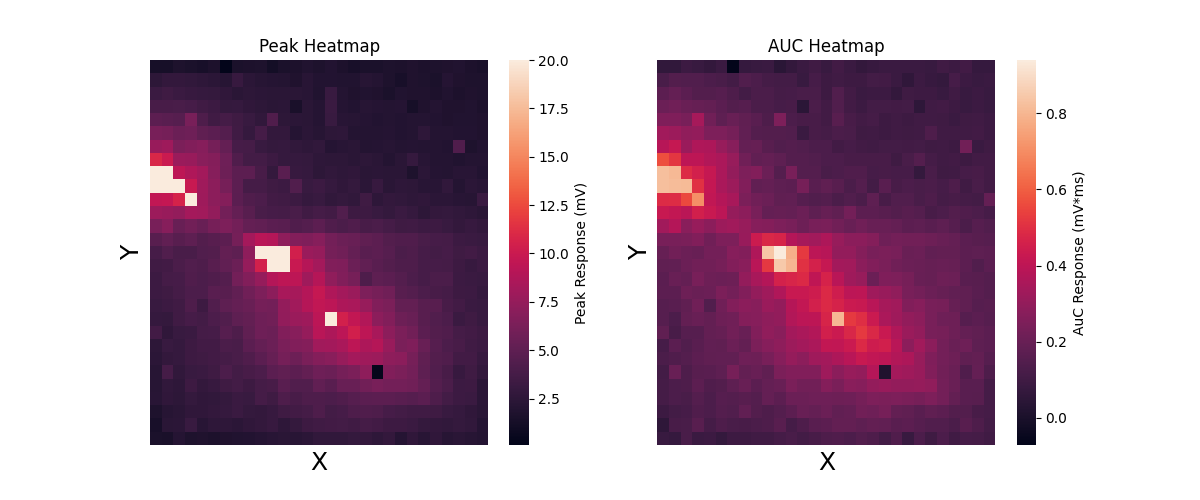

In [69]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\May17\30May17\Expt3_300517\Expt3_300517_Ordered_Grid_29.mat") # CaMK18 300517
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Asymmetries\Recording\Apr18\27Apr18\59xgrid29roi_100perc10ms.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//59, (c-1)%59
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK18_300517_expt03'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')

c:\venvs\venv-ephys\Lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


dict_keys(['__header__', '__version__', '__globals__', 'AnalysedFile', 'AnalysedFilePath', 'AucImageFile', 'ExptID', 'FileName', 'PatchTrace', 'PatchTracelets', 'PathName', 'PeakImageFile', 'PolygonTrace', 'TimeTrace', 'TraceFile', 'ans', 'aucDuration', 'aucTime', 'coord', 'coordFileName', 'coordFilePathName', 'fid', 'gridAuc', 'None', 'gridPeak', 'gridSize', 'j', 'locs', 'peaks', '__function_workspace__'])


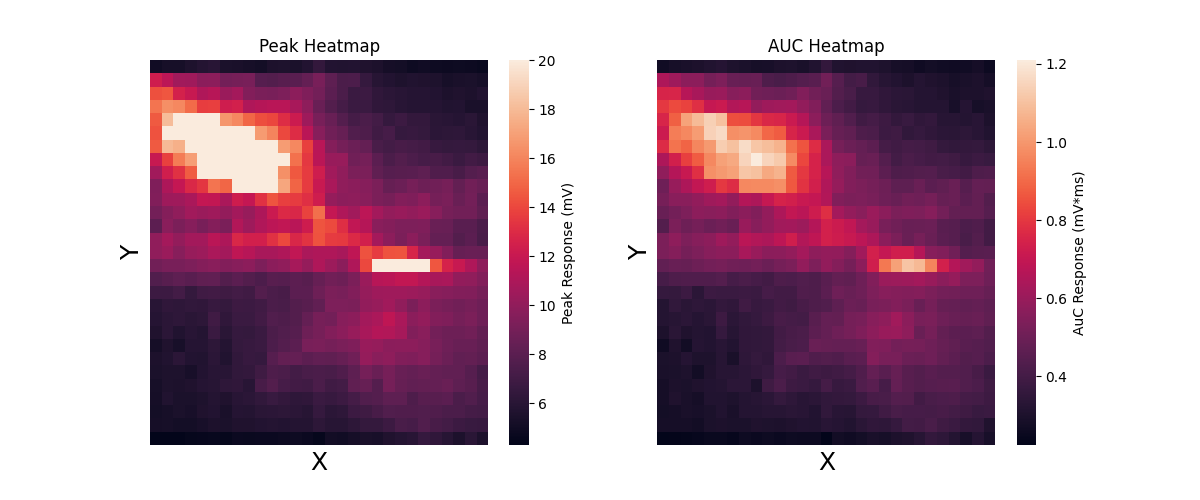

In [70]:
# load matlab files
matfile = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_170817\Expt05_170817_Ordered_Grid_29.mat")
mat = sio.loadmat(matfile)
print(mat.keys())
protocol_path6 = Path(r"C:\Users\adity\OneDrive\NCBS\Lab\Projects\Sequences\Analyses\Aug17\17Aug17\Expt05_grid29_random.txt")
coord = pd.read_csv(protocol_path6, header=None, sep=' ')

data = mat['PatchTracelets']
# coord = mat['coord']
# coord = coord.ravel()

fig4, [ax4_1, ax4_2] = plt.subplots(1,2, figsize=(12,5))
peakdict = []
for i,c in enumerate(coord[3]):
    x,y = (c-1)//29, (c-1)%29
    cellslice = data[i]
    cellmax = np.max(cellslice)
    cellauc = np.trapz(cellslice) / 20000
    if cellmax>20:
        cellmax=20

    peakdict.append({'x':x, 'y':y, 'peak':cellmax, 'auc':cellauc})

peak_df = pd.DataFrame(peakdict)
df_pivot_peak = peak_df.pivot(index='x', columns='y', values='peak')
df_pivot_auc  = peak_df.pivot(index='x', columns='y', values='auc')

# heatmap
sns.heatmap(df_pivot_peak, ax=ax4_1, cmap='rocket')
sns.heatmap(df_pivot_auc, ax=ax4_2, cmap='rocket')

ax4_1.set_title('Peak Heatmap')
# remove x and y labels, ticks and grid
ax4_1.set_xticks([])
ax4_1.set_yticks([])
ax4_1.set_xticklabels([])
ax4_1.set_yticklabels([])
# axs labels
ax4_1.set_xlabel('X', fontsize=18)
ax4_1.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_1.collections[0].colorbar
unit = 'mV'
cbar.set_label(f'Peak Response ({unit})')

ax4_2.set_title('AUC Heatmap')
# remove x and y labels, ticks and grid
ax4_2.set_xticks([])
ax4_2.set_yticks([])
ax4_2.set_xticklabels([])
ax4_2.set_yticklabels([])
# axs labels
ax4_2.set_xlabel('X', fontsize=18)
ax4_2.set_ylabel('Y', fontsize=18)
# add colorbar label
cbar = ax4_2.collections[0].colorbar
unit = 'mV*ms'
cbar.set_label(f'AuC Response ({unit})')

filename_prefix = f'CaMK31_170817_expt05'
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.svg')
fig4.savefig(fig_folder / f'{filename_prefix}_heatmap.png')